In [1]:
# pip install plotly

In [2]:
import pandas as pd
from prophet import Prophet
# from astral import moon
import datetime as dt
import matplotlib.pyplot as plt
from datetime import timedelta
%matplotlib inline

In [3]:
# Import Houston crime data and moon files
houston_data_file = 'Houston_Crime_Data_Source_File.csv'

# Read the data into a pandas dataframe
houston_data = pd.read_csv(houston_data_file)

houston_data.info()

C:\Users\resto\AppData\Local\Temp\ipykernel_17924\3243566670.py:5: DtypeWarning: Columns (2,10) have mixed types. Specify dtype option on import or set low_memory=False.
  houston_data = pd.read_csv(houston_data_file)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185474 entries, 0 to 1185473
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   Unnamed: 0         1185474 non-null  int64 
 1   Date               1185474 non-null  object
 2   Hour               1185474 non-null  object
 3   Offense Type       1185474 non-null  object
 4   Beat               1185458 non-null  object
 5   Premise            1169553 non-null  object
 6   BlockRange         1185474 non-null  object
 7   StreetName         1184583 non-null  object
 8   Type               1185474 non-null  object
 9   Suffix             1173737 non-null  object
 10  # offenses         1042377 non-null  object
 11  CleanedStreetName  1173220 non-null  object
dtypes: int64(1), object(11)
memory usage: 108.5+ MB


In [4]:
# Change Occurance Date to datetime format
houston_data['Date'] = pd.to_datetime(houston_data['Date'])

# Display DataFrame info and first 5 rows
houston_data.info()
houston_data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185474 entries, 0 to 1185473
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   Unnamed: 0         1185474 non-null  int64         
 1   Date               1185474 non-null  datetime64[ns]
 2   Hour               1185474 non-null  object        
 3   Offense Type       1185474 non-null  object        
 4   Beat               1185458 non-null  object        
 5   Premise            1169553 non-null  object        
 6   BlockRange         1185474 non-null  object        
 7   StreetName         1184583 non-null  object        
 8   Type               1185474 non-null  object        
 9   Suffix             1173737 non-null  object        
 10  # offenses         1042377 non-null  object        
 11  CleanedStreetName  1173220 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 108.5+ MB


,Unnamed: 0,Date,Hour,Offense Type,Beat,Premise,BlockRange,StreetName,Type,Suffix,# offenses,CleanedStreetName
1185469,1275917,2013-11-28,23,Theft,20G10,20A,9800-9899,MEADOWGLEN,LN,-,1,MEADOWGLEN LN -
1185470,1275918,2013-11-29,3,Theft,18F30,18N,5900-5999,RICHMOND,AVE,-,1,RICHMOND AVE -
1185471,1275919,2013-11-29,4,Theft,5F20,18A,1500-1599,BIG BEND,DR,-,1,BIG BEND DR -
1185472,1275920,2013-11-27,18,Theft,6B30,18O,6800-6899,PINE VISTA,LN,-,1,PINE VISTA LN -
1185473,1275921,2013-11-28,20,Theft,7C50,18P,15700-15799,MORALES,RD,-,1,MORALES RD -


In [5]:
# Reduce original data down to only the needed rows, Data and Offense Type
reduced_houston_data = houston_data[['Date', 'Offense Type']]

# Rename Offense Type to Offense
reduced_houston_data = reduced_houston_data.rename(columns={'Offense Type': 'Offense'})
reduced_houston_data.reset_index(drop=True)

# RS Attempted to Sort DF, to see Min max using Head / Tail
# RS DF would not sort, so created a new DF and verified Min & Max dates
reduced_houston_sorted = reduced_houston_data.sort_values(["Date"], ascending=True)

# Display DataFrame info and first 5 rows
# print(reduced_houston_data['Date'].dtype)
# reduced_houston_data.info()
reduced_houston_sorted.tail(10)



,Date,Offense
275147,2018-12-31,"Destruction, damage, vandalism"
275148,2018-12-31,"Destruction, damage, vandalism"
275149,2018-12-31,Motor vehicle theft
275150,2018-12-31,Intimidation
275151,2018-12-31,All other larceny
275152,2018-12-31,"Burglary, Breaking and Entering"
275153,2018-12-31,"Destruction, damage, vandalism"
275154,2018-12-31,Simple assault
275156,2018-12-31,All other larceny
275515,2018-12-31,Weapon law violations


In [6]:
# RS Separate cell created to verify Min & Max Dates for Houston Crimes (= 1-1-2010 through 12-31-2018)
min_houston_date = reduced_houston_data["Date"].min()
max_houston_date = reduced_houston_data["Date"].max()
print(f"Earliest Houston Crime Date in this DF is = ", {min_houston_date})
print(f"Latest Houston Crime Date in this DF is = ", {max_houston_date})

Earliest Houston Crime Date in this DF is =  {Timestamp('2010-01-01 00:00:00')}
Latest Houston Crime Date in this DF is =  {Timestamp('2018-12-31 00:00:00')}


In [7]:
# Import moon file
moon_data_file = 'moon_data_export.csv'

# Read the moon data into a pandas dataframe
moon_df = pd.read_csv(moon_data_file)

moon_df.info()
moon_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Moon Phase             500 non-null    object
 1   Date                   500 non-null    object
 2   Time (Universal Time)  500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


,Moon Phase,Date,Time (Universal Time)
0,Last Quarter,2023-01-15,02:10
1,New Moon,2023-01-21,20:53
2,First Quarter,2023-01-28,15:19
3,Full Moon,2023-02-05,18:28
4,Last Quarter,2023-02-13,16:01


In [8]:
# RS Separate cell created to verify Min & Max Moon Data Dates (VERIFIED Range = 1-1-2010 through 12-31-2018)
min_moon_data_date = moon_df["Date"].min()
max_moon_data_date = moon_df["Date"].max()
print(f"Earliest Moon Data Crime Date in this DF is = ", {min_moon_data_date})
print(f"Latest Moon Data Date in this DF is = ", {max_moon_data_date})

Earliest Moon Data Crime Date in this DF is =  {'2014-01-16'}
Latest Moon Data Date in this DF is =  {'2024-01-11'}


In [9]:
# # RS Reduce the Houston Data to match the Date range of the moon data 
# # Sort and then Filter:
# reduced_houston_data = reduced_houston_data.sort_values('Date')
# filtered_houston_data = reduced_houston_data [
#     (reduced_houston_data['Date'] >= pd.to_datetime('2014-01-16')) &
#     (reduced_houston_data['Date'] <= pd.to_datetime('2018-12-31'))
# ].reset_index(drop=True)

# # print("Earliest Houston Crime Date in this DF is = ", reduced_houston_data['Date'].min)
# # print("Latest Houston Crime Date in this DF is = ", reduced_houston_data['Date'].max)

# # filtered_houston_data.head()
# filtered_houston_data.tail()
# RS - Above did not work, Trying another method: (Set date Rages with Varibles)

# RS First ensure column is in DateTime Format:
reduced_houston_data['Date'] = pd.to_datetime(reduced_houston_data['Date'])
moon_df['Date'] = pd.to_datetime(moon_df['Date'])

# RS Next, Sort values
reduced_houston_data = reduced_houston_data.sort_values('Date')
moon_df = moon_df.sort_values('Date')

# set start and Stop date range - set Overlap start & stop varibles
overlap_start = pd.to_datetime('2014-01-16')
overlap_stop = pd.to_datetime('2018-12-31')

filtered_houston_data = reduced_houston_data[
    (reduced_houston_data['Date'] >= overlap_start) &
    (reduced_houston_data['Date'] <= overlap_stop)
].reset_index(drop=True)

filtered_moon_data = moon_df[
    (moon_df['Date'] >= overlap_start) &
    (moon_df['Date'] <= overlap_stop)
].reset_index(drop=True)


filtered_houston_data.tail()
# filtered_moon_data.tail()

,Date,Offense
669775,2018-12-31,"Burglary, Breaking and Entering"
669776,2018-12-31,"Destruction, damage, vandalism"
669777,2018-12-31,Simple assault
669778,2018-12-31,All other larceny
669779,2018-12-31,Weapon law violations


In [10]:
# Change Date to datetime format
# moon_df['Date'] = pd.to_datetime(moon_df['Date'])

# Display moon_df info and first 5 rows
# filtered_moon_data.info()
filtered_moon_data.tail()

,Moon Phase,Date,Time (Universal Time)
243,Last Quarter,2018-11-30,00:19
244,New Moon,2018-12-07,07:20
245,First Quarter,2018-12-15,11:49
246,Full Moon,2018-12-22,17:49
247,Last Quarter,2018-12-29,09:34


In [11]:
# # Reduce original data down to only the needed rows, Date and Moon Phase
# reduced_moon_data = moon_df[['Date', 'Moon Phase']]

# # Display reduced Houston info and first 5 rows
# reduced_moon_data.info()
# reduced_moon_data.head()

# RS Point to new Moon DF "filtered_moon_data"
filtered_moon_data = filtered_moon_data[['Date', 'Moon Phase']]

# Display reduced Houston info and first 5 rows
# filtered_moon_data.info()
filtered_moon_data.tail()

,Date,Moon Phase
243,2018-11-30,Last Quarter
244,2018-12-07,New Moon
245,2018-12-15,First Quarter
246,2018-12-22,Full Moon
247,2018-12-29,Last Quarter


In [12]:
# Expand Moon Phase Dates by ±1 day
# RS:  for every moon phase, its range has been extended one day before and after 
expanded_moon_data = []
for x, row in filtered_moon_data.iterrows():
    moon_date = row['Date']
    moon_phase = row['Moon Phase']
    # Create a 3-day range: moon_date ± 1 day
    # RS Adjust to incorporate more days in the range to help normalize moon phase data (adjustimg +/- from 1 to 2)
    for day in pd.date_range(moon_date - pd.Timedelta(days=2), moon_date + pd.Timedelta(days=2)):
        expanded_moon_data.append({'Date': day, 'Moon Phase': moon_phase})

# Convert expanded data into a DataFrame
expanded_moon_data = pd.DataFrame(expanded_moon_data)

# Merge on the Date column
# RS Merge Houston Merged Lunar Data & Expanded Moon Data on the Date column
# merged_houston_lunar_data = pd.merge(filtered_moon_data, expanded_moon_data, on='Date', how='left')
merged_houston_lunar_data = pd.merge(filtered_houston_data, expanded_moon_data, on='Date', how='left')

# Update the Moon Phase column to "Other" for all phases that are not "New Moon" or "Full Moon"
merged_houston_lunar_data['Moon Phase'] = merged_houston_lunar_data['Moon Phase'].apply(
    lambda x: x 
    if x in ['New Moon', 'Full Moon'] 
    else 'Other')

# Step 3: Inspect the result
merged_houston_lunar_data.tail(10)


,Date,Offense,Moon Phase
673275,2018-12-31,"Destruction, damage, vandalism",Other
673276,2018-12-31,"Destruction, damage, vandalism",Other
673277,2018-12-31,Motor vehicle theft,Other
673278,2018-12-31,Intimidation,Other
673279,2018-12-31,All other larceny,Other
673280,2018-12-31,"Burglary, Breaking and Entering",Other
673281,2018-12-31,"Destruction, damage, vandalism",Other
673282,2018-12-31,Simple assault,Other
673283,2018-12-31,All other larceny,Other
673284,2018-12-31,Weapon law violations,Other


In [13]:
# Create a pivot table to count the number of offenses per Moon Phase
lunar_phase_pivot_table = merged_houston_lunar_data.pivot_table(
    index='Moon Phase',     # Rows of the pivot table
    values='Offense',       # Column to aggregate (e.g., counting offenses)
    aggfunc='count'         # Aggregation function (count the number of offenses)
)

# Display the pivot table
print(lunar_phase_pivot_table.head())

# RS Difference of 730 phases in what should be close to even - Seems odd.  Doing basic math:
# RS Pseudo Code:  (Other 1050122) - (Full Moon + New Moon SUM 137,500) = 912,622 
#print(lunar_phase_pivot_table.columns)
total = (lunar_phase_pivot_table.loc["Full Moon"] + lunar_phase_pivot_table.loc["New Moon"]).values[0]
print(f"Total rows for Full and New Moon Phases = {total}")

new_total = (lunar_phase_pivot_table.loc["Other"] - (lunar_phase_pivot_table.loc["Full Moon"] + lunar_phase_pivot_table.loc["New Moon"])).values[0]
print(f"Total rows for 'Full and New Moon Phases,' subtracted from Other (phases) = {new_total}")
# This seems to be a big Discrepancy - Why ?

            Offense
Moon Phase         
Full Moon    113789
New Moon     114689
Other        444807
Total rows for Full and New Moon Phases = 228478
Total rows for 'Full and New Moon Phases,' subtracted from Other (phases) = 216329


In [14]:
# Count the number of offenses per Moon Phase
crime_counts = merged_houston_lunar_data.groupby('Moon Phase')['Offense'].count()

# Calculate the total number of offenses
total_crimes = crime_counts.sum()

# Calculate the crime rate percentage for each Moon Phase
crime_rate_percentage = (crime_counts / total_crimes) * 100

# Reset the index and rename the columns
crime_rate_df = crime_rate_percentage.reset_index()
crime_rate_df.columns = ['Moon Phase', 'Crime Rate (%)']

# Display the crime rate DataFrame
crime_rate_df


,Moon Phase,Crime Rate (%)
0,Full Moon,16.900570
1,New Moon,17.034243
2,Other,66.065188


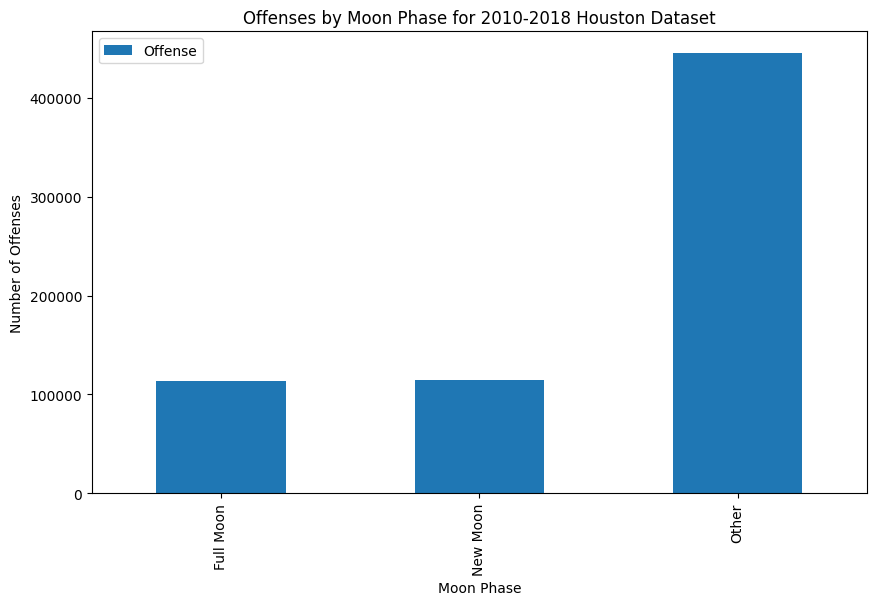

In [15]:
# Bar plot of offenses by moon phase
lunar_phase_pivot_table.plot(kind='bar', figsize=(10, 6), title='Offenses by Moon Phase for 2010-2018 Houston Dataset')
plt.xlabel('Moon Phase')
plt.ylabel('Number of Offenses')

# RS Slightly Adjusted Bar Plot:
plt.ticklabel_format(style='plain', axis='y' )
plt.show()